# 1. Import Packages

In [201]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import Ridge

# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet


# 2. Model Class

In [2]:
class Model:
    
    def get_target(self,df):
        df['return'] = (df['f24'].shift(-78) - df['f24']) / df['f24']
        df['return'] = df['return'].replace([np.inf,-np.inf],0)
        return df[['return']]
    
    
    def prepare_features(self, df):
        """
        :param df: this is the data you want to use to prepare the features for your model
        :return: X, a matrix of features (can be a numpy array or a pandas dataframe, your choice!)
        """
        # todo: implement this function - you can use some of the features given to you or you can build a batch of
        #  your own based on the data that you are given.
        # *** PLEASE ENSURE THAT DO NOT INTRODUCE A LOOKAHEAD IN THIS MATRIX ***
        # *** Bonus points for coding a function that tests against lookahead in X ***
        
        ## 2. Convert columns to return format
        return_type_columns = ['f0','f1','f2','f3','f11','f12']
        price_type_columns = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9',
           'f10', 'f13', 'f16', 'f17', 'f18', 'f19',
           'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
           'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
           'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49',
           'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59',
           'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69',
           'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76']
        integer_type_columns = ['f14','f15','f77','f78']

        for col in price_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
    
        for col in integer_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
        
        req_cols = integer_type_columns+price_type_columns+return_type_columns
        X = df[req_cols]
        
        X = X.replace([np.inf,-np.inf],0)
        X = X.fillna(0)
        
        return X

    
    def fit(self, path_to_train_csv, *args, **kwargs):
        """
        ### AG:  TASKS
        ## Model Selection: 
            Linear: Base Model
            Ridge : Handles Multicollinearity
            RandomForest (large number of uncorrelated features, fail if the potential y values lie outside)
            Time Series
        ## Train-Test Split to get the optimal model
        ## Train complete model
        ## Store the optimal model
        """
        
        # todo: read train csv
        # todo: do any operation you would like on it
        ## 1. Read the data
        self.train = pd.read_csv(path_to_train_csv, index_col='time', parse_dates=['time'])
        self.train.index = pd.to_datetime(self.train.index, format='%d-%m-%Y %H:%M')
        self.train.sort_index(inplace=True)
        self.train = self.train.fillna(method='ffill')
        
#       # todo: prepare features for the model fit
        ## 2. Prepare y and X variables
        self.y = self.get_target(self.train)
        self.X = self.prepare_features(self.train)
        
        
        ## 3. Drop missing rows
        combined = pd.concat([self.X, self.y], axis=1)
        combined_clean = combined.dropna()
        self.X_clean = combined_clean.drop(columns='return')
        self.y_clean = combined_clean['return']
        
        ## 4. Fit and Cross Validate your model
        # todo: fit your model here - use X (features matrix), y (the target variable) and any other information you
        #  want to use
        alpha = 0
        alpha *= self.X_clean.shape[0]
        self.model = sm.OLS(self.y_clean,self.X_clean).fit_regularized(method='elastic_net', L1_wt=1, alpha=alpha)
        
        return self

    
    def predict(self, path_to_test_csv, *args, **kwargs):
        # todo: read test csv
        # todo: do any operation you would like on it
        self.test = pd.read_csv(path_to_test_csv, index_col='time', parse_dates=['time'])
        self.test.index = pd.to_datetime(self.test.index, format='%d-%m-%Y %H:%M')
        self.test.sort_index(inplace=True)
        self.test = self.test.fillna(method='ffill')
    
        # todo: prepare features for the model predict
        self.y_test = self.get_target(self.test)
        self.X_test = self.prepare_features(self.test)
        

        # todo: calculate your model prediction (call it ypred) using X and any other information you want to use
        ypred = pd.Series(np.nan, index=self.X_test.index)
        non_nan_rows = ~self.X_test.isnull().any(axis=1)
        ypred[non_nan_rows] = self.model.predict(self.X_test[non_nan_rows])

        # this follows the scikit-learn pattern by returning ypred
        return ypred

In [3]:
def get_rmse(ypred,ytest):
    combined = pd.concat([ypred, ytest], axis=1)
    combined_clean = combined.dropna()
    
    rmse_ = rmse(combined_clean[0],combined_clean['return'])
    return rmse_

In [4]:
# if __name__ == '__main__':
train_csv_path = '../data/train.csv'
test_csv_path = '../data/test.csv'

fit_args = []  # todo: populate this as you see fit
fit_kwargs = {}  # todo: populate this as you see fit
clf = Model()

clf.fit(train_csv_path, *fit_args, **fit_kwargs)

predict_args = []  # todo: populate this as you see fit
predict_kwargs = {}  # todo: populate this as you see fit
ypred = clf.predict(test_csv_path, *predict_args, **predict_kwargs)

# alpha=1
get_rmse(ypred,clf.y_test)

0.015601655403819666

<Axes: xlabel='time'>

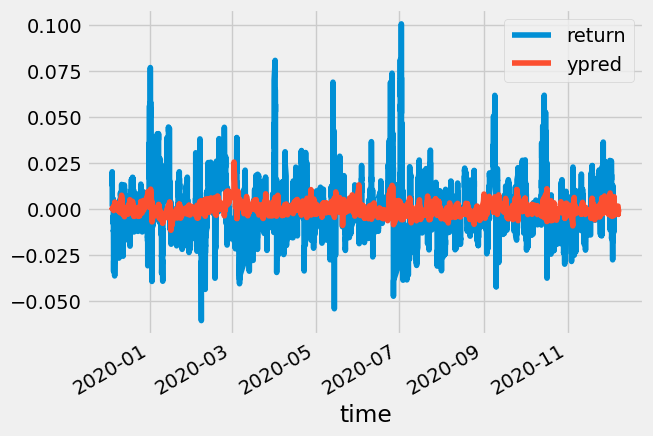

In [5]:
clf.y_test['ypred'] = ypred

clf.y_test.plot()

In [6]:
# if __name__ == '__main__':
train_csv_path = '../data/train.csv'
test_csv_path = '../data/test.csv'

fit_args = []  # todo: populate this as you see fit
fit_kwargs = {}  # todo: populate this as you see fit
clf = Model()

clf.fit(train_csv_path, *fit_args, **fit_kwargs)

predict_args = []  # todo: populate this as you see fit
predict_kwargs = {}  # todo: populate this as you see fit
ypred = clf.predict(test_csv_path, *predict_args, **predict_kwargs)

# lasso 1
get_rmse(ypred,clf.y_test)

0.015601655403819666

In [263]:
clf.y_test['ypred'] = ypred

<Axes: xlabel='time'>

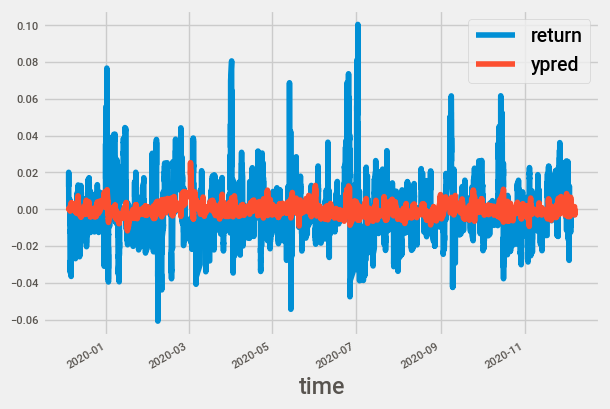

In [264]:
clf.y_test.plot()

# 3. Data Cleaning

### 3.1 Missing Value Treatment

In [220]:
data = pd.read_csv('../candidate.csv', index_col='time', parse_dates=['time'])
data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')
data.sort_index(inplace=True)
data = data.fillna(method='ffill')

### 3.2 Data Transformation: Convert all columns to 24 hour return format

- Scaling
- No Lookahead bias
- Returns are predictors of returns of interest

In [221]:
# converting requisite columns
return_type_columns = ['f0','f1','f2','f3','f11','f12']
price_type_columns = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9',
   'f10', 'f13', 'f16', 'f17', 'f18', 'f19',
   'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
   'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
   'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49',
   'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59',
   'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69',
   'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76']
integer_type_columns = ['f14','f15','f77','f78']

for col in price_type_columns:
    data[col] = (data[col] - data[col].shift(78))/data[col].shift(78)

for col in integer_type_columns:
    data[col] = (data[col] - data[col].shift(78))/data[col].shift(78)
    
# handle case of infinity    
data = data.replace([np.inf],1)
data = data.replace([-np.inf],-1)

In [222]:
data

f0        f1        f2        f3        f4  \
time                                                                    
2015-11-18 09:30:00  0.000000  0.000000  0.000000  0.000000       NaN   
2015-11-18 09:35:00  0.001689 -0.001088  0.000058  0.000615       NaN   
2015-11-18 09:40:00  0.004288  0.004110  0.001356  0.000040       NaN   
2015-11-18 09:45:00  0.000268  0.008612  0.006797 -0.001845       NaN   
2015-11-18 09:50:00  0.001404 -0.005846 -0.003133  0.001615       NaN   
...                       ...       ...       ...       ...       ...   
2020-12-07 14:11:00 -0.000019  0.000390  0.000007 -0.000126 -0.017862   
2020-12-07 14:16:00  0.000281  0.000352  0.000380 -0.000022 -0.017751   
2020-12-07 14:21:00 -0.000741 -0.000277 -0.000005 -0.000143 -0.018369   
2020-12-07 14:26:00  0.001594  0.002589  0.000373 -0.000308 -0.014281   
2020-12-07 14:31:00  0.001561  0.001207 -0.000497  0.000109 -0.015064   

                           f5        f6        f7        f8        f9  ...  \
time                                                                   ...   
2015-11-18 09:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2015-11-18 09:35:00       NaN       NaN       NaN       NaN       NaN  ...   
2015-11-18 09:40:00       NaN       NaN       NaN       NaN       NaN  ...   
2015-11-18 09:45:00       NaN       NaN       NaN       NaN       NaN  ...   
2015-11-18 09:50:00       NaN       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2020-12-07 14:11:00 -0.032542 -0.034904 -0.036745 -0.015485 -0.034904  ...   
2020-12-07 14:16:00 -0.030810 -0.033159 -0.034151 -0.013855 -0.033159  ...   
2020-12-07 14:21:00 -0.029075 -0.030621 -0.032428 -0.011429 -0.031469  ...   
2020-12-07 14:26:00 -0.026385 -0.027948 -0.029772 -0.011391 -0.027948  ...   
2020-12-07 14:31:00 -0.030783 -0.033159 -0.034996 -0.016287 -0.034904  ...   

                        f69       f70       f71       f72       f73       f74  \
time                                                                            
2015-11-18 09:30:00     NaN       NaN       NaN       NaN       NaN       NaN   
2015-11-18 09:35:00     NaN       NaN       NaN       NaN       NaN       NaN   
2015-11-18 09:40:00     NaN       NaN       NaN       NaN       NaN       NaN   
2015-11-18 09:45:00     NaN       NaN       NaN       NaN       NaN       NaN   
2015-11-18 09:50:00     NaN       NaN       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
2020-12-07 14:11:00 -0.0001  0.007967  0.008175 -0.000200  0.008171  0.008518   
2020-12-07 14:16:00 -0.0001  0.007556  0.007901 -0.000300  0.007760  0.008245   
2020-12-07 14:21:00 -0.0001  0.006870  0.007490 -0.000599  0.007074  0.008107   
2020-12-07 14:26:00  0.0001  0.006803  0.006808 -0.000100  0.007075  0.007494   
2020-12-07 14:31:00  0.0000  0.006667  0.006738 -0.000100  0.007007  0.007425   

                          f75       f76       f77       f78  
time                                                         
2015-11-18 09:30:00       NaN       NaN       NaN       NaN  
2015-11-18 09:35:00       NaN       NaN       NaN       NaN  
2015-11-18 09:40:00       NaN       NaN       NaN       NaN  
2015-11-18 09:45:00       NaN       NaN       NaN       NaN  
2015-11-18 09:50:00       NaN       NaN       NaN       NaN  
...                       ...       ...       ...       ...  
2020-12-07 14:11:00 -0.000300  0.290764 -0.569753 -0.669565  
2020-12-07 14:16:00 -0.000599  3.508319  0.942149  0.512195  
2020-12-07 14:21:00 -0.001098 -0.843601 -0.681250 -0.173077  
2020-12-07 14:26:00 -0.000399 -0.102194  0.883521  0.200000  
2020-12-07 14:31:00 -0.000399 -0.783578 -0.420432  0.246154  

[100000 rows x 79 columns]

### 3.3 Drop Highly Correlated Variables (Corr>0.9)

1. delete f5-f9, keep f10

In [195]:
data.drop(columns=['f5','f6','f7','f9','f8'],inplace=True)

2. delete f25,f26,f28,f29,f31,f32,f34,f35 keep f24

In [196]:
data.drop(columns=['f25','f26','f28','f29','f31','f32','f34','f35'],inplace=True)

3. delete f37,f38,f39,f42,f44,f45,f47,f48 keep f41

In [197]:
data.drop(columns=['f37','f38','f39','f42','f44','f45','f47','f48'],inplace=True)

4. delete f51,f52,f54,f55,f57,f58,,f60,f61 keep f50

In [198]:
data.drop(columns=['f51','f52','f54','f55','f57','f58','f60','f61'],inplace=True)

5. delete f65,f64,f67,f63,f71,f70,f74,f73 keep f68

In [199]:
data.drop(columns=['f65','f64','f67','f63','f71','f70','f74','f73'],inplace=True)

### 3.4 Outlier Treatment

In [214]:
window_size = 20*79  # 1 working week

rolling_mean = data.rolling(window=window_size, min_periods=1).mean()
rolling_std = data.rolling(window=window_size, min_periods=1).std()

threshold = 2

lower_bound = rolling_mean - threshold * rolling_std
upper_bound = rolling_mean + threshold * rolling_std

for column in data.columns:
    data[column] = data[column].clip(lower=lower_bound[column], upper=upper_bound[column], axis=0)


In [216]:
my_report = sv.analyze(data)
my_report.show_html() 

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<Axes: xlabel='time'>

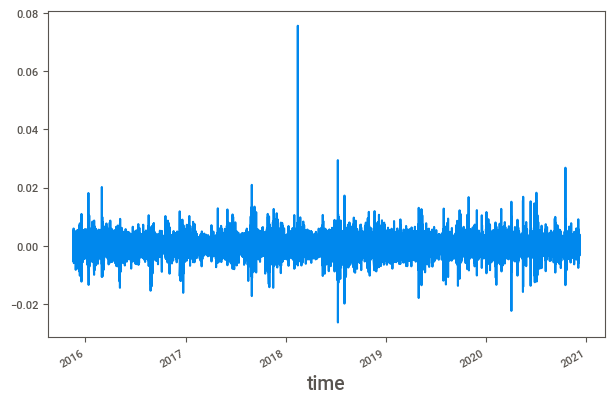

In [204]:
data['f0'].plot()

### 3.5 Visualization

In [205]:
import dtale
d = dtale.show(data)
d

# 4. Modified Model Class

- Running for OLS, Ridge, Lasso, Elastic Net
- Simple X variables

In [47]:
class Model:
    
    def get_target(self,df):
        df['return'] = (df['f24'].shift(-78) - df['f24']) / df['f24']
        df['return'] = df['return'].replace([np.inf,-np.inf],0)
        return df[['return']]
    
    
    def prepare_features(self, df):
        """
        :param df: this is the data you want to use to prepare the features for your model
        :return: X, a matrix of features (can be a numpy array or a pandas dataframe, your choice!)
        """
        # todo: implement this function - you can use some of the features given to you or you can build a batch of
        #  your own based on the data that you are given.
        # *** PLEASE ENSURE THAT DO NOT INTRODUCE A LOOKAHEAD IN THIS MATRIX ***
        # *** Bonus points for coding a function that tests against lookahead in X ***
        
        ## 1. Data Transformation
        return_type_columns = ['f0','f1','f2','f3','f11','f12']
        price_type_columns = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9',
           'f10', 'f13', 'f16', 'f17', 'f18', 'f19',
           'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
           'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
           'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49',
           'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59',
           'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69',
           'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76']
        integer_type_columns = ['f14','f15','f77','f78']

        for col in price_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
    
        for col in integer_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
        
        req_cols = integer_type_columns+price_type_columns+return_type_columns
        X = df[req_cols]
        
        # handle case of infinity    
        X = X.replace([np.inf],1)
        X = X.replace([-np.inf],-1)
        
        
        ## 2. Drop highly correlated variables
        X.drop(columns=['f5','f6','f7','f9','f8'],inplace=True)
        X.drop(columns=['f25','f26','f28','f29','f31','f32','f34','f35'],inplace=True)
        X.drop(columns=['f37','f38','f39','f42','f44','f45','f47','f48'],inplace=True)
        X.drop(columns=['f51','f52','f54','f55','f57','f58','f60','f61'],inplace=True)
        X.drop(columns=['f65','f64','f67','f63','f71','f70','f74','f73'],inplace=True)
        
        
        ## 3. Outlier Treatment
        window_size = 20*79  # 1 month (working days only) 
        threshold = 2
        rolling_mean = X.rolling(window=window_size, min_periods=1).mean()
        rolling_std = X.rolling(window=window_size, min_periods=1).std()
        lower_bound = rolling_mean - threshold * rolling_std
        upper_bound = rolling_mean + threshold * rolling_std
        for column in X.columns:
            X[column] = X[column].clip(lower=lower_bound[column], upper=upper_bound[column], axis=0)

        
        return X

    
    def fit(self, path_to_train_csv, *args, **kwargs):
        """
        ### AG:  TASKS
        ## Model Selection: 
            Linear: Base Model
            Ridge : Handles Multicollinearity
            RandomForest (large number of uncorrelated features, fail if the potential y values lie outside)
            Time Series
        ## Train-Test Split to get the optimal model
        ## Train complete model
        ## Store the optimal model
        """
        
        # todo: read train csv
        # todo: do any operation you would like on it
#         self.train = pd.read_csv(path_to_train_csv)
        self.train = pd.read_csv(path_to_train_csv, index_col='time', parse_dates=['time'])
        self.train.index = pd.to_datetime(self.train.index, format='%d-%m-%Y %H:%M')
        self.train.sort_index(inplace=True)
        self.train = self.train.fillna(method='ffill')
        
#         # todo: prepare features for the model fit
        self.y = self.get_target(self.train)
        self.X = self.prepare_features(self.train)        
        
        ## AG: Drop missing values
        combined = pd.concat([self.X, self.y], axis=1)
        combined_clean = combined.dropna()
        self.X_clean = combined_clean.drop(columns='return')
        self.y_clean = combined_clean['return']
        
        
        
        # Sequential split into train, cv, and test sets
        total_length = len(self.X_clean)
        train_size = int(total_length * 0.8)  # 60% of data for training
#         test_size = int(total_length * 0.2)     # 20% of data for cross-validation

        X_train,y_train = self.X_clean[:train_size], self.y_clean[:train_size]
        X_test,y_test = self.X_clean[train_size:], self.y_clean[train_size:]

        
        
        # Range of hyperparameters to test for Lasso, Ridge, and Elastic Net
        alphas = kwargs['alphas']
        best_alpha = None
        lowest_cv_rmse = float('inf')
        best_model = None
        lowest_rmse = float('inf')
        best_model_name = None
        
        res_list = []
        
        for model_type in args:
            if model_type == 'ols':
                model = LinearRegression()
                model.fit(X_train, y_train)
                
                y_pred = pd.Series(np.nan, index=X_test.index)
                non_nan_rows = ~X_test.isnull().any(axis=1)
                y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
#                 print(y_pred)
#                 print(y_test)
                test_rmse = get_rmse(y_test,y_pred)
                res_list.append({'model':model_type,'alpha':None,'test_rmse':test_rmse})
                
                if test_rmse<lowest_rmse:
                    lowest_rmse = test_rmse
                    best_model = model
                    best_model_name = model_type
                    
            else:
                total_length = len(X_train)
                train_size = int(total_length * 0.8)
                X_train_fold,y_train_fold = X_train[:train_size], y_train[:train_size]
                X_cv_fold,y_cv_fold = X_train[train_size:], y_train[train_size:]

                # test for lasso model
                if model_type=='lasso':
                    lowest_cv_rmse = float('inf')
                    for alpha in alphas:
                        model = Lasso(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
                        print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Lasso(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

            
                # test for ridge model
                if model_type=='ridge':
                    lowest_cv_rmse = float('inf')
                    for alpha in alphas:
                        model = Ridge(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
                        print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Ridge(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

                        
                        
                # test for ridge model
                if model_type=='elastic_net':
                    lowest_cv_rmse = float('inf')
                    best_l1_ratio = 0
                    for alpha in alphas:
                        for l1_ratio in alphas:
                            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                            model.fit(X_train_fold,y_train_fold)
                            y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                            non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                            y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                            cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
                            print("model: {}, alpha: {}, l1_ratio: {},cv_rmse: {}".format(model_type,alpha,l1_ratio,cv_rmse))
                            if cv_rmse<lowest_cv_rmse:
                                best_alpha = alpha
                                best_l1_ratio = l1_ratio
                                lowest_cv_rmse = cv_rmse

                    # get the test_rmse for the model
                    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)

                    res_list.append({'model':model_type,'alpha':(best_alpha,best_l1_ratio),'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type
        
    
        self.model = best_model
        self.model_name = best_model_name
        return self


    
    def predict(self, path_to_test_csv, *args, **kwargs):
        # todo: read test csv
        # todo: do any operation you would like on it
        self.test = pd.read_csv(path_to_test_csv, index_col='time', parse_dates=['time'])
        self.test.index = pd.to_datetime(self.test.index, format='%d-%m-%Y %H:%M')
        self.test.sort_index(inplace=True)
        self.test = self.test.fillna(method='ffill')
    
        # todo: prepare features for the model predict
        self.y_test = self.get_target(self.test)
        self.X_test = self.prepare_features(self.test)
        

        # todo: calculate your model prediction (call it ypred) using X and any other information you want to use
        ypred = pd.Series(np.nan, index=self.X_test.index)
        non_nan_rows = ~self.X_test.isnull().any(axis=1)
        ypred[non_nan_rows] = self.model.predict(self.X_test[non_nan_rows])

        # this follows the scikit-learn pattern by returning ypred
        return ypred

In [48]:
# if __name__ == '__main__':
train_csv_path = '../data/train.csv'
test_csv_path = '../data/test.csv'

fit_args = ['ols','lasso','ridge','elastic_net']  # todo: populate this as you see fit
fit_kwargs = {'alphas':np.linspace(0,1,11)}  # todo: populate this as you see fit
clf = Model()

clf.fit(train_csv_path, *fit_args, **fit_kwargs)

model: lasso, alpha: 0.0, cv_rmse: 0.02098352989951035
model: lasso, alpha: 0.1, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.2, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.30000000000000004, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.4, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.5, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.6000000000000001, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.7000000000000001, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.8, cv_rmse: 0.021057124584281196
model: lasso, alpha: 0.9, cv_rmse: 0.021057124584281196
model: lasso, alpha: 1.0, cv_rmse: 0.021057124584281196
model: ridge, alpha: 0.0, cv_rmse: 0.020983529899510363
model: ridge, alpha: 0.1, cv_rmse: 0.0210035060024643
model: ridge, alpha: 0.2, cv_rmse: 0.02100713321326221
model: ridge, alpha: 0.30000000000000004, cv_rmse: 0.02100889286698094
model: ridge, alpha: 0.4, cv_rmse: 0.021009899758395793
model: ridge, alpha: 0.5, cv_rmse: 0.0210104514

model: elastic_net, alpha: 0.7000000000000001, l1_ratio: 0.6000000000000001,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.7000000000000001, l1_ratio: 0.7000000000000001,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.7000000000000001, l1_ratio: 0.8,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.7000000000000001, l1_ratio: 0.9,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.7000000000000001, l1_ratio: 1.0,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0.0,cv_rmse: 0.020992627264833953
model: elastic_net, alpha: 0.8, l1_ratio: 0.1,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0.2,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0.30000000000000004,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0.4,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0.5,cv_rmse: 0.021057124584281196
model: elastic_net, alpha: 0.8, l1_ratio: 0

In [49]:
clf.model

Ridge(alpha=0.0)

In [50]:
predict_args = []  # todo: populate this as you see fit
predict_kwargs = {}  # todo: populate this as you see fit
ypred = clf.predict(test_csv_path, *predict_args, **predict_kwargs)

In [51]:
get_rmse(ypred,clf.y_test)

0.015817932482357088

# 4. Modified Model Class

- Running for OLS, Ridge, Lasso, Elastic Net
- Lag of y and X

In [212]:
class Model:
    
    def get_target(self,df):
        df['return'] = (df['f24'].shift(-78) - df['f24']) / df['f24']
        df['return'] = df['return'].replace([np.inf,-np.inf],0)
        return df[['return']]
    
    
    def prepare_features(self, df):
        """
        :param df: this is the data you want to use to prepare the features for your model
        :return: X, a matrix of features (can be a numpy array or a pandas dataframe, your choice!)
        """
        # todo: implement this function - you can use some of the features given to you or you can build a batch of
        #  your own based on the data that you are given.
        # *** PLEASE ENSURE THAT DO NOT INTRODUCE A LOOKAHEAD IN THIS MATRIX ***
        # *** Bonus points for coding a function that tests against lookahead in X ***
        
        ## 1. Data Transformation
        return_type_columns = ['f0','f1','f2','f3','f11','f12']
        price_type_columns = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9',
           'f10', 'f13', 'f16', 'f17', 'f18', 'f19',
           'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
           'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
           'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49',
           'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59',
           'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69',
           'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76']
        integer_type_columns = ['f14','f15','f77','f78']

        for col in price_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
    
        for col in integer_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
        
        X = df
        
        # handle case of infinity    
        X = X.replace([np.inf],1)
        X = X.replace([-np.inf],-1)
        
        
        ## 2. Drop highly correlated variables
        X.drop(columns=['f5','f6','f7','f9','f8'],inplace=True)
        X.drop(columns=['f25','f26','f28','f29','f31','f32','f34','f35'],inplace=True)
        X.drop(columns=['f37','f38','f39','f42','f44','f45','f47','f48'],inplace=True)
        X.drop(columns=['f51','f52','f54','f55','f57','f58','f60','f61'],inplace=True)
        X.drop(columns=['f65','f64','f67','f63','f71','f70','f74','f73'],inplace=True)
        
        
        ## 3. Outlier Treatment
        window_size = 20*79  # 1 month (working days only) 
        threshold = 2
        rolling_mean = X.rolling(window=window_size, min_periods=1).mean()
        rolling_std = X.rolling(window=window_size, min_periods=1).std()
        lower_bound = rolling_mean - threshold * rolling_std
        upper_bound = rolling_mean + threshold * rolling_std
        req_cols = list(X.columns)
        req_cols.remove('return')
        print("req_cols without 'return' ", req_cols)
        for column in req_cols:   
            X[column] = X[column].clip(lower=lower_bound[column], upper=upper_bound[column], axis=0)

        # include lag column
#         column_name = 'return'
        for column_name in X.columns:
            for i in range(1, self.lag + 1):
                lagged_column_name = f'{column_name}_lag_{i}'
                X[lagged_column_name] = X[column_name].shift(i*78)
        
        # delete return columns
        del X['return']
        
        return X
    
    
#     def create_lagged_columns(df, column_name, lag_order):
#         for i in range(1, lag_order + 1):
#             lagged_column_name = f'{column_name}_lag_{i}'
#             df[lagged_column_name] = df[column_name].shift(i)

#     # Example: create 2 lagged columns for 'return'
#     create_lagged_columns(df, 'return', 2)
    
    
    def read_data(self,path_to_data):
        data = pd.read_csv(path_to_data, index_col='time', parse_dates=['time'])
        data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')
        data.sort_index(inplace=True)
        data = data.fillna(method='ffill')
        return data
        
    
    def fit(self, path_to_train_csv, *args, **kwargs):
        """
        ### AG:  TASKS
        ## Model Selection: 
            Linear: Base Model
            Ridge : Handles Multicollinearity
            RandomForest (large number of uncorrelated features, fail if the potential y values lie outside)
            Time Series
        ## Train-Test Split to get the optimal model
        ## Train complete model
        ## Store the optimal model
        """
        
        # get the values from kwargs
        self.alphas = kwargs['alphas']
        self.lag = kwargs['lag']
        self.l1_ratio = kwargs['l1_ratio']
        
        
        # todo: read train csv
        # todo: do any operation you would like on it
        self.train = self.read_data(path_to_train_csv)
        
        # todo: prepare features for the model fit
        self.y = self.get_target(self.train)
        self.X = self.prepare_features(self.train)        
        
        ## AG: Drop missing values
        combined = pd.concat([self.X, self.y], axis=1)
        combined_clean = combined.dropna()
        self.X_clean = combined_clean.drop(columns='return')
        self.y_clean = combined_clean['return']
        
        
        
        # Sequential split into train, cv, and test sets
        total_length = len(self.X_clean)
        train_size = int(total_length * 0.8)  # 60% of data for training
#         test_size = int(total_length * 0.2)     # 20% of data for cross-validation

        X_train,y_train = self.X_clean[:train_size], self.y_clean[:train_size]
        X_test,y_test = self.X_clean[train_size:], self.y_clean[train_size:]

        
        
        # Range of hyperparameters to test for Lasso, Ridge, and Elastic Net
        best_alpha = None
        lowest_cv_rmse = float('inf')
        best_model = None
        lowest_rmse = float('inf')
        best_model_name = None
        
        res_list = []
        
        for model_type in args:
            if model_type == 'ols':
                model = LinearRegression()
                model.fit(X_train, y_train)
                
                y_pred = pd.Series(np.nan, index=X_test.index)
                non_nan_rows = ~X_test.isnull().any(axis=1)
                y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
#                 print(y_pred)
#                 print(y_test)
                test_rmse = get_rmse(y_test,y_pred)
                res_list.append({'model':model_type,'lag':self.lag,'alpha':None,'test_rmse':test_rmse})
                
                if test_rmse<lowest_rmse:
                    lowest_rmse = test_rmse
                    best_model = model
                    best_model_name = model_type
                    
            else:
                total_length = len(X_train)
                train_size = int(total_length * 0.8)
                X_train_fold,y_train_fold = X_train[:train_size], y_train[:train_size]
                X_cv_fold,y_cv_fold = X_train[train_size:], y_train[train_size:]

                # test for lasso model
                if model_type=='lasso':
                    lowest_cv_rmse = float('inf')
                    for alpha in self.alphas:
                        model = Lasso(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                         print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Lasso(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'lag':self.lag,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

            
                # test for ridge model
                if model_type=='ridge':
                    lowest_cv_rmse = float('inf')
                    for alpha in self.alphas:
                        model = Ridge(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                         print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Ridge(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'lag':self.lag,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

                        
                        
                # test for ridge model
                if model_type=='elastic_net':
                    lowest_cv_rmse = float('inf')
                    best_l1_ratio = 0
                    for alpha in self.alphas:
                        for l1_ratio in self.l1_ratio:
                            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                            model.fit(X_train_fold,y_train_fold)
                            y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                            non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                            y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                            cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                             print("model: {}, alpha: {}, l1_ratio: {},cv_rmse: {}".format(model_type,alpha,l1_ratio,cv_rmse))
                            if cv_rmse<lowest_cv_rmse:
                                best_alpha = alpha
                                best_l1_ratio = l1_ratio
                                lowest_cv_rmse = cv_rmse

                    # get the test_rmse for the model
                    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)

                    res_list.append({'model':model_type,'lag':self.lag,'alpha':(best_alpha,best_l1_ratio),'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type
        
    
        self.model = best_model
        self.model_name = best_model_name
        self.res_list = res_list
        return self


    
    def predict(self, path_to_test_csv, *args, **kwargs):
        # todo: read test csv
        # todo: do any operation you would like on it
        self.test = pd.read_csv(path_to_test_csv, index_col='time', parse_dates=['time'])
        self.test.index = pd.to_datetime(self.test.index, format='%d-%m-%Y %H:%M')
        self.test.sort_index(inplace=True)
        self.test = self.test.fillna(method='ffill')
    
        # todo: prepare features for the model predict
        self.y_test = self.get_target(self.test)
        self.X_test = self.prepare_features(self.test)
        

        # todo: calculate your model prediction (call it ypred) using X and any other information you want to use
        ypred = pd.Series(np.nan, index=self.X_test.index)
        non_nan_rows = ~self.X_test.isnull().any(axis=1)
        ypred[non_nan_rows] = self.model.predict(self.X_test[non_nan_rows])

        # this follows the scikit-learn pattern by returning ypred
        return ypred

In [213]:
# # if __name__ == '__main__':
# train_csv_path = '../data/train.csv'
# test_csv_path = '../data/test.csv'

# fit_args = ['ols']#['ols','lasso','ridge','elastic_net']  # todo: populate this as you see fit
# fit_kwargs = {'alphas':np.linspace(0,1,11),'lag':1,'l1_ratio':np.linspace(0,1,11)}  # todo: populate this as you see fit
# clf = Model()

# clf.fit(train_csv_path, *fit_args, **fit_kwargs)

In [214]:
# if __name__ == '__main__':
train_csv_path = '../data/train.csv'
test_csv_path = '../data/test.csv'

fit_args = ['ridge']  # todo: populate this as you see fit

result_df = pd.DataFrame()


fit_kwargs = {'alphas':[1],'lag':3,'l1_ratio':[0]} # todo: populate this as you see fit
clf = Model()
clf.fit(train_csv_path, *fit_args, **fit_kwargs)
result_df = pd.concat([result_df,pd.DataFrame(clf.res_list)])

predict_args = []  # todo: populate this as you see fit
predict_kwargs = {}  # todo: populate this as you see fit
ypred = clf.predict(test_csv_path, *predict_args, **predict_kwargs)
get_rmse(ypred, clf.y_test)

req_cols without 'return'  ['f0', 'f1', 'f2', 'f3', 'f4', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f27', 'f30', 'f33', 'f36', 'f40', 'f41', 'f43', 'f46', 'f49', 'f50', 'f53', 'f56', 'f59', 'f62', 'f66', 'f68', 'f69', 'f72', 'f75', 'f76', 'f77', 'f78']
req_cols without 'return'  ['f0', 'f1', 'f2', 'f3', 'f4', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f27', 'f30', 'f33', 'f36', 'f40', 'f41', 'f43', 'f46', 'f49', 'f50', 'f53', 'f56', 'f59', 'f62', 'f66', 'f68', 'f69', 'f72', 'f75', 'f76', 'f77', 'f78']


0.01581098734827609

In [215]:
# # if __name__ == '__main__':
# train_csv_path = '../data/train.csv'
# test_csv_path = '../data/test.csv'

# fit_args = ['ols','lasso','ridge','elastic_net']  # todo: populate this as you see fit

# result_df = pd.DataFrame()

# for l in list(range(0,8)):
#     fit_kwargs = {'alphas':np.linspace(0,1,11),'lag':l,'l1_ratio':np.linspace(0,1,11)} # todo: populate this as you see fit
#     clf = Model()
#     clf.fit(train_csv_path, *fit_args, **fit_kwargs)
#     result_df = pd.concat([result_df,pd.DataFrame(clf.res_list)])
#     print(clf.res_list)

In [216]:
# result_df.to_csv('results_y_x_lag.csv')

In [217]:
# result_df

# 5. Modified Model Class

- Running for OLS, Ridge, Lasso, Elastic Net
- Lag of y 

In [218]:
class Model:
    
    def get_target(self,df):
        df['return'] = (df['f24'].shift(-78) - df['f24']) / df['f24']
        df['return'] = df['return'].replace([np.inf,-np.inf],0)
        return df[['return']]
    
    
    def prepare_features(self, df):
        """
        :param df: this is the data you want to use to prepare the features for your model
        :return: X, a matrix of features (can be a numpy array or a pandas dataframe, your choice!)
        """
        # todo: implement this function - you can use some of the features given to you or you can build a batch of
        #  your own based on the data that you are given.
        # *** PLEASE ENSURE THAT DO NOT INTRODUCE A LOOKAHEAD IN THIS MATRIX ***
        # *** Bonus points for coding a function that tests against lookahead in X ***
        
        ## 1. Data Transformation
        return_type_columns = ['f0','f1','f2','f3','f11','f12']
        price_type_columns = ['f4', 'f5', 'f6', 'f7', 'f8', 'f9',
           'f10', 'f13', 'f16', 'f17', 'f18', 'f19',
           'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29',
           'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39',
           'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49',
           'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59',
           'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69',
           'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76']
        integer_type_columns = ['f14','f15','f77','f78']

        for col in price_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
    
        for col in integer_type_columns:
            df[col] = (df[col] - df[col].shift(78))/df[col].shift(78)
        
        X = df
        
        # handle case of infinity    
        X = X.replace([np.inf],1)
        X = X.replace([-np.inf],-1)
        
        
        ## 2. Drop highly correlated variables
        X.drop(columns=['f5','f6','f7','f9','f8'],inplace=True)
        X.drop(columns=['f25','f26','f28','f29','f31','f32','f34','f35'],inplace=True)
        X.drop(columns=['f37','f38','f39','f42','f44','f45','f47','f48'],inplace=True)
        X.drop(columns=['f51','f52','f54','f55','f57','f58','f60','f61'],inplace=True)
        X.drop(columns=['f65','f64','f67','f63','f71','f70','f74','f73'],inplace=True)
        
        
        ## 3. Outlier Treatment
        window_size = 20*79  # 1 month (working days only) 
        threshold = 2
        rolling_mean = X.rolling(window=window_size, min_periods=1).mean()
        rolling_std = X.rolling(window=window_size, min_periods=1).std()
        lower_bound = rolling_mean - threshold * rolling_std
        upper_bound = rolling_mean + threshold * rolling_std
        req_cols = list(X.columns)
        req_cols.remove('return')
        print("req_cols without 'return' ", req_cols)
        for column in req_cols:   
            X[column] = X[column].clip(lower=lower_bound[column], upper=upper_bound[column], axis=0)

        # include lag column
        column_name = 'return'
        for i in range(1, self.lag + 1):
            lagged_column_name = f'{column_name}_lag_{i}'
            X[lagged_column_name] = X[column_name].shift(i*78)

        # delete return columns
        del X['return']
        
        return X
    
    
#     def create_lagged_columns(df, column_name, lag_order):
#         for i in range(1, lag_order + 1):
#             lagged_column_name = f'{column_name}_lag_{i}'
#             df[lagged_column_name] = df[column_name].shift(i)

#     # Example: create 2 lagged columns for 'return'
#     create_lagged_columns(df, 'return', 2)
    
    
    def read_data(self,path_to_data):
        data = pd.read_csv(path_to_data, index_col='time', parse_dates=['time'])
        data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')
        data.sort_index(inplace=True)
        data = data.fillna(method='ffill')
        return data
        
    
    def fit(self, path_to_train_csv, *args, **kwargs):
        """
        ### AG:  TASKS
        ## Model Selection: 
            Linear: Base Model
            Ridge : Handles Multicollinearity
            RandomForest (large number of uncorrelated features, fail if the potential y values lie outside)
            Time Series
        ## Train-Test Split to get the optimal model
        ## Train complete model
        ## Store the optimal model
        """
        
        # get the values from kwargs
        self.alphas = kwargs['alphas']
        self.lag = kwargs['lag']
        self.l1_ratio = kwargs['l1_ratio']
        
        
        # todo: read train csv
        # todo: do any operation you would like on it
        self.train = self.read_data(path_to_train_csv)
        
        # todo: prepare features for the model fit
        self.y = self.get_target(self.train)
        self.X = self.prepare_features(self.train)        
        
        ## AG: Drop missing values
        combined = pd.concat([self.X, self.y], axis=1)
        combined_clean = combined.dropna()
        self.X_clean = combined_clean.drop(columns='return')
        self.y_clean = combined_clean['return']
        
        
        
        # Sequential split into train, cv, and test sets
        total_length = len(self.X_clean)
        train_size = int(total_length * 0.8)  # 60% of data for training
#         test_size = int(total_length * 0.2)     # 20% of data for cross-validation

        X_train,y_train = self.X_clean[:train_size], self.y_clean[:train_size]
        X_test,y_test = self.X_clean[train_size:], self.y_clean[train_size:]

        
        
        # Range of hyperparameters to test for Lasso, Ridge, and Elastic Net
        best_alpha = None
        lowest_cv_rmse = float('inf')
        best_model = None
        lowest_rmse = float('inf')
        best_model_name = None
        
        res_list = []
        
        for model_type in args:
            if model_type == 'ols':
                model = LinearRegression()
                model.fit(X_train, y_train)
                
                y_pred = pd.Series(np.nan, index=X_test.index)
                non_nan_rows = ~X_test.isnull().any(axis=1)
                y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
#                 print(y_pred)
#                 print(y_test)
                test_rmse = get_rmse(y_test,y_pred)
                res_list.append({'model':model_type,'lag':self.lag,'alpha':None,'test_rmse':test_rmse})
                
                if test_rmse<lowest_rmse:
                    lowest_rmse = test_rmse
                    best_model = model
                    best_model_name = model_type
                    
            else:
                total_length = len(X_train)
                train_size = int(total_length * 0.8)
                X_train_fold,y_train_fold = X_train[:train_size], y_train[:train_size]
                X_cv_fold,y_cv_fold = X_train[train_size:], y_train[train_size:]

                # test for lasso model
                if model_type=='lasso':
                    lowest_cv_rmse = float('inf')
                    for alpha in self.alphas:
                        model = Lasso(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                         print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Lasso(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'lag':self.lag,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

            
                # test for ridge model
                if model_type=='ridge':
                    lowest_cv_rmse = float('inf')
                    for alpha in self.alphas:
                        model = Ridge(alpha=alpha)
                        model.fit(X_train_fold,y_train_fold)
                        y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                        non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                        y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                        cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                         print("model: {}, alpha: {}, cv_rmse: {}".format(model_type,alpha,cv_rmse))
                        if cv_rmse<lowest_cv_rmse:
                            best_alpha = alpha
                            lowest_cv_rmse = cv_rmse
                    
                    # get the test_rmse for the model
                    model = Ridge(alpha=best_alpha)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)
                    
                    res_list.append({'model':model_type,'lag':self.lag,'alpha':best_alpha,'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type

                        
                        
                # test for ridge model
                if model_type=='elastic_net':
                    lowest_cv_rmse = float('inf')
                    best_l1_ratio = 0
                    for alpha in self.alphas:
                        for l1_ratio in self.l1_ratio:
                            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                            model.fit(X_train_fold,y_train_fold)
                            y_cv_pred = pd.Series(np.nan, index=X_cv_fold.index)
                            non_nan_rows = ~X_cv_fold.isnull().any(axis=1)
                            y_cv_pred[non_nan_rows] = model.predict(X_cv_fold[non_nan_rows])
                            cv_rmse = get_rmse(y_cv_fold,y_cv_pred)
#                             print("model: {}, alpha: {}, l1_ratio: {},cv_rmse: {}".format(model_type,alpha,l1_ratio,cv_rmse))
                            if cv_rmse<lowest_cv_rmse:
                                best_alpha = alpha
                                best_l1_ratio = l1_ratio
                                lowest_cv_rmse = cv_rmse

                    # get the test_rmse for the model
                    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
                    model.fit(X_train, y_train)
                    y_pred = pd.Series(np.nan, index=X_test.index)
                    non_nan_rows = ~X_test.isnull().any(axis=1)
                    y_pred[non_nan_rows] = model.predict(X_test[non_nan_rows])
                    test_rmse = get_rmse(y_test,y_pred)

                    res_list.append({'model':model_type,'lag':self.lag,'alpha':(best_alpha,best_l1_ratio),'test_rmse':test_rmse})
                    if test_rmse<lowest_rmse:
                        lowest_rmse = test_rmse
                        best_model = model
                        best_model_name = model_type
        
    
        self.model = best_model
        self.model_name = best_model_name
        self.res_list = res_list
        return self


    
    def predict(self, path_to_test_csv, *args, **kwargs):
        # todo: read test csv
        # todo: do any operation you would like on it
        self.test = pd.read_csv(path_to_test_csv, index_col='time', parse_dates=['time'])
        self.test.index = pd.to_datetime(self.test.index, format='%d-%m-%Y %H:%M')
        self.test.sort_index(inplace=True)
        self.test = self.test.fillna(method='ffill')
    
        # todo: prepare features for the model predict
        self.y_test = self.get_target(self.test)
        self.X_test = self.prepare_features(self.test)
        

        # todo: calculate your model prediction (call it ypred) using X and any other information you want to use
        ypred = pd.Series(np.nan, index=self.X_test.index)
        non_nan_rows = ~self.X_test.isnull().any(axis=1)
        ypred[non_nan_rows] = self.model.predict(self.X_test[non_nan_rows])

        # this follows the scikit-learn pattern by returning ypred
        return ypred

In [219]:
# if __name__ == '__main__':
train_csv_path = '../data/train.csv'
test_csv_path = '../data/test.csv'

fit_args = ['ridge']  # todo: populate this as you see fit

result_df = pd.DataFrame()


fit_kwargs = {'alphas':[1],'lag':21,'l1_ratio':[0]} # todo: populate this as you see fit
clf = Model()
clf.fit(train_csv_path, *fit_args, **fit_kwargs)
result_df = pd.concat([result_df,pd.DataFrame(clf.res_list)])

predict_args = []  # todo: populate this as you see fit
predict_kwargs = {}  # todo: populate this as you see fit
ypred = clf.predict(test_csv_path, *predict_args, **predict_kwargs)
get_rmse(ypred, clf.y_test)

req_cols without 'return'  ['f0', 'f1', 'f2', 'f3', 'f4', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f27', 'f30', 'f33', 'f36', 'f40', 'f41', 'f43', 'f46', 'f49', 'f50', 'f53', 'f56', 'f59', 'f62', 'f66', 'f68', 'f69', 'f72', 'f75', 'f76', 'f77', 'f78']
req_cols without 'return'  ['f0', 'f1', 'f2', 'f3', 'f4', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f27', 'f30', 'f33', 'f36', 'f40', 'f41', 'f43', 'f46', 'f49', 'f50', 'f53', 'f56', 'f59', 'f62', 'f66', 'f68', 'f69', 'f72', 'f75', 'f76', 'f77', 'f78']


0.0158491350757922

In [211]:
# # if __name__ == '__main__':
# train_csv_path = '../data/train.csv'
# test_csv_path = '../data/test.csv'

# fit_args = ['ols','lasso','ridge','elastic_net']  # todo: populate this as you see fit

# result_df = pd.DataFrame()

# for l in list(range(0,32)):
#     fit_kwargs = {'alphas':np.linspace(0,1,11),'lag':l,'l1_ratio':np.linspace(0,1,11)} # todo: populate this as you see fit
#     clf = Model()
#     clf.fit(train_csv_path, *fit_args, **fit_kwargs)
#     result_df = pd.concat([result_df,pd.DataFrame(clf.res_list)])
#     print(clf.res_list)

In [210]:
# result_df.to_csv('result_y_lag.csv')